In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import statsmodels.api as sm
import missingno as mno

# Load the data

In [25]:
data = pd.read_excel('dataset.xlsx')

# Data Preprocessing and Cleaning

## Rename columns

In [26]:
data = data.rename(columns = {'sex(man=1,woman=0)':'sex',
                              'neck circumference（cm）':'neck', 
                              'waist circumference（cm）':'waist', 
                              'maximum interincisal distance（cm）':'mid',
                              'Mallampati test':'Mt', 
                              'ratio of Height to thyro-sternum distance':'rhtd', 
                              'ESS questionnaire':'ESS',
                              'STOP-Bang questionnaire':'SB',
                              'no or mild OSA: moderate-severe OSA(0:1)':'result'})

In [27]:
data[['sex', 'age', 'neck', 'waist', 'BMI', 'mid', 'Mt', 'rhtd', 'ESS', 'SB']].isnull().sum()

sex      0
age      0
neck     0
waist    0
BMI      0
mid      2
Mt       0
rhtd     0
ESS      0
SB       0
dtype: int64

<AxesSubplot:>

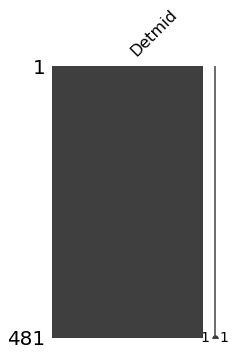

In [28]:
missing_columns = ['mid']

def random_imputation(df, feature):
    
    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace=True)
    
    return df
for feature in missing_columns:
    data[feature + "_imp"] = data[feature]
    data = random_imputation(data, feature)
    
deter_data = pd.DataFrame(columns=["Det" + name for name in missing_columns])

for feature in missing_columns:
    
    deter_data["Det" + feature] = data[feature + "_imp"]
    parameters = list(set(data.columns) - set(missing_columns) - {feature + '_imp'})
    
    #Create a Linear Regression model to estimate the missing data
    lr = linear_model.LinearRegression()
    lr.fit(X = data[parameters], y= data[feature + "_imp"])
    
    #Preserve the index of the missing data from the original dataframe
    deter_data.loc[data[feature].isnull(), "Det" + feature] = lr.predict(data[parameters])[data[feature].isnull()]

mno.matrix(deter_data, figsize=(3, 5))

In [29]:
data= pd.concat([data[['sex', 'age', 'neck', 'waist', 'BMI', 'Mt', 'rhtd', 'ESS', 'SB', 'result']], deter_data[['Detmid']]], axis = 1)
data

,sex,age,neck,waist,BMI,Mt,rhtd,ESS,SB,result,Detmid
0,1,37,38.0,83.0,22.491349,1,15.454545,0,2,0,6.0
1,1,31,40.0,89.0,22.093170,3,19.777778,4,3,0,5.0
2,1,43,37.0,86.0,22.491349,1,18.888889,3,3,0,6.0
3,1,30,37.0,89.0,23.255019,1,15.545455,3,2,0,6.0
4,1,53,39.0,99.0,27.335640,1,18.888889,13,5,0,5.0
...,...,...,...,...,...,...,...,...,...,...,...
476,0,69,32.0,86.0,21.258503,2,18.666667,9,5,0,4.0
477,0,62,34.5,85.0,24.464602,2,18.111111,5,2,1,5.0
478,0,61,34.0,76.0,24.609375,1,20.000000,0,2,1,5.5
479,0,63,36.0,83.0,19.467401,1,18.333333,0,1,1,6.0


# Modelling

## RandomForestClassifier

Text(0.5, 257.44, 'Predicted label')

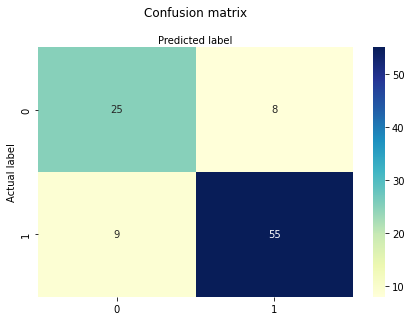

In [30]:
X = data[['sex', 'Mt', 'Detmid', 'age', 'neck', 'waist', 'BMI', 'rhtd', 'ESS', 'SB']]
y = data['result']
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, random_state=42)
model1 = RandomForestClassifier()
model1.fit(X_trn, y_trn)
y_pred1 = model1.predict(X_tst)
matrix1 = confusion_matrix(y_tst,y_pred1)
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(matrix1), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [31]:
Mic_RandomForest = metrics.f1_score(y_tst, y_pred1, average ='micro')
Mac_RandomForest = metrics.f1_score(y_tst, y_pred1, average ='macro')
print("Macro-average: {0}".format(Mic_RandomForest))
print("Micro-average: {0}".format(Mac_RandomForest))
print(metrics.classification_report(y_tst, y_pred1))
print(metrics.confusion_matrix(y_tst, y_pred1))

Macro-average: 0.8247422680412371
Micro-average: 0.8062051944999413
              precision    recall  f1-score   support

           0       0.74      0.76      0.75        33
           1       0.87      0.86      0.87        64

    accuracy                           0.82        97
   macro avg       0.80      0.81      0.81        97
weighted avg       0.83      0.82      0.83        97

[[25  8]
 [ 9 55]]


## ExtraTreesClassifier

Text(0.5, 257.44, 'Predicted label')

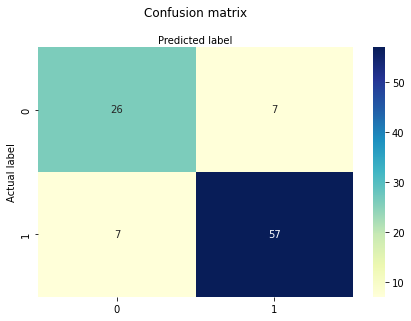

In [32]:
model2 = ExtraTreesClassifier()
model2.fit(X_trn, y_trn)
y_pred2 = model2.predict(X_tst)
matrix2 = confusion_matrix(y_tst,y_pred2)
confusion_matrix(y_tst, y_pred2)
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(matrix2), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [33]:
Mac_ExtraTrees = metrics.f1_score(y_tst, y_pred2, average ='macro')
Mic_ExtraTrees = metrics.f1_score(y_tst, y_pred2, average ='micro')
print("Macro-average: {0}".format(Mac_ExtraTrees))
print("Micro-average: {0}".format(Mic_ExtraTrees))
print(metrics.classification_report(y_tst, y_pred2))
print(metrics.confusion_matrix(y_tst, y_pred2))

Macro-average: 0.8392518939393939
Micro-average: 0.8556701030927835
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        33
           1       0.89      0.89      0.89        64

    accuracy                           0.86        97
   macro avg       0.84      0.84      0.84        97
weighted avg       0.86      0.86      0.86        97

[[26  7]
 [ 7 57]]


## BaggingClassifier

Text(0.5, 257.44, 'Predicted label')

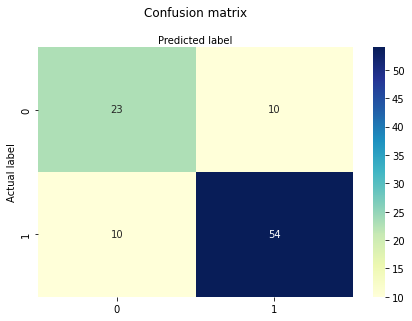

In [34]:
model3 = BaggingClassifier(RandomForestClassifier(), n_estimators=10)
model3.fit(X_trn, y_trn)
y_pred3 = model3.predict(X_tst)
matrix3 = confusion_matrix(y_tst,y_pred3)
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(matrix3), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [35]:
Mac_Bagging = metrics.f1_score(y_tst, y_pred3, average ='macro')
Mic_Bagging = metrics.f1_score(y_tst, y_pred3, average ='micro')
print("Macro-average: {0}".format(Mac_Bagging))
print("Micro-average: {0}".format(Mic_Bagging))
print(metrics.classification_report(y_tst, y_pred3))
print(metrics.confusion_matrix(y_tst, y_pred3))

Macro-average: 0.7703598484848485
Micro-average: 0.7938144329896907
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        33
           1       0.84      0.84      0.84        64

    accuracy                           0.79        97
   macro avg       0.77      0.77      0.77        97
weighted avg       0.79      0.79      0.79        97

[[23 10]
 [10 54]]


## KNeighborsClassifier

Text(0.5, 257.44, 'Predicted label')

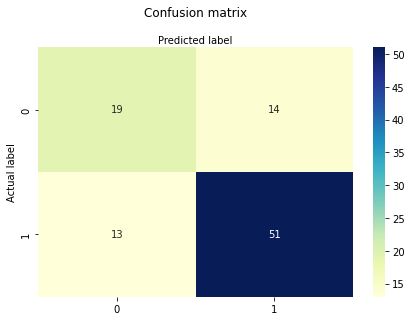

In [36]:
model6 = KNeighborsClassifier()
model6.fit(X_trn, y_trn)
y_pred6 = model6.predict(X_tst)
matrix6 = confusion_matrix(y_tst,y_pred6)
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(matrix6), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [37]:
print("Macro-average: {0}".format(metrics.f1_score(y_tst, y_pred6, average ='macro')))
print("Micro-average: {0}".format(metrics.f1_score(y_tst, y_pred6, average ='micro')))
print(metrics.classification_report(y_tst, y_pred6))
print(metrics.confusion_matrix(y_tst, y_pred6))

Macro-average: 0.6876565295169946
Micro-average: 0.7216494845360826
              precision    recall  f1-score   support

           0       0.59      0.58      0.58        33
           1       0.78      0.80      0.79        64

    accuracy                           0.72        97
   macro avg       0.69      0.69      0.69        97
weighted avg       0.72      0.72      0.72        97

[[19 14]
 [13 51]]


# Feature Selection

In [38]:
X = data[['sex', 'age', 'neck', 'waist', 'BMI', 'Detmid', 'Mt', 'rhtd', 'ESS', 'SB']]
y = data['result']

### Univariate

In [39]:
#Select the best features
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X ,y)
dfscore = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscore], axis=1)
featureScores.columns = ['Features', 'Score'] #naming the dataframe columns
print(featureScores.nlargest(10, 'Score')) #print 5 best features

  Features      Score
1      age  59.504241
3    waist  53.964149
7     rhtd  28.450988
9       SB  16.389726
8      ESS  13.923471
2     neck  13.594773
4      BMI  11.748331
0      sex   6.823036
6       Mt   1.705740
5   Detmid   0.800719


### Feature importance

[0.04917844 0.11023767 0.10159059 0.12450911 0.10799272 0.08066754
 0.06004896 0.16079271 0.11201108 0.09297118]


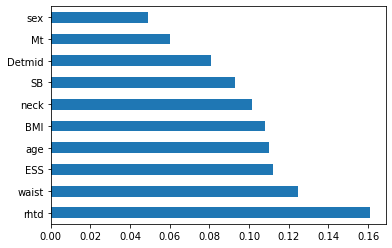

In [40]:
md = ExtraTreesClassifier()
md.fit(X,y)
print(md.feature_importances_)
feat_importances = pd.Series(md.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind ='barh')
plt.show()

[0.0294697  0.12184884 0.09897541 0.13936391 0.13504992 0.05591303
 0.03122743 0.21030305 0.10462137 0.07322734]


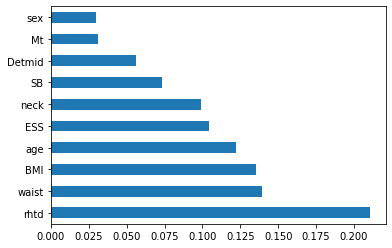

In [41]:
rf_model = RandomForestClassifier()
rf_model.fit(X, y)
print(rf_model.feature_importances_)
feat_importances = pd.Series(rf_model.feature_importances_, index = X.columns)
feat_importances.nlargest(10).plot(kind = 'barh')
plt.show()

### Correlation Matrix with Heatmap

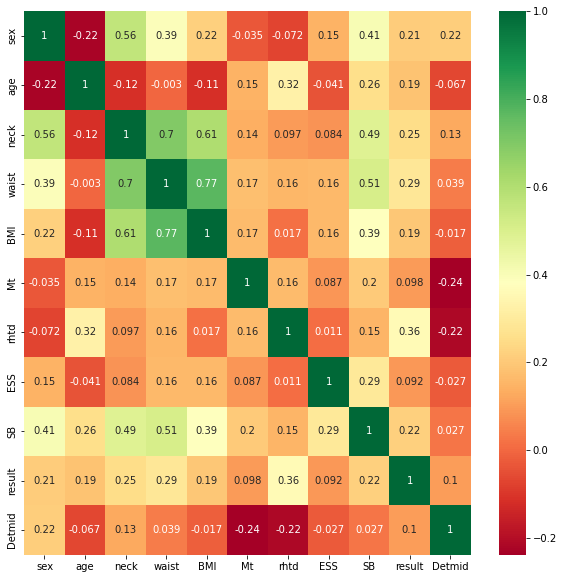

In [42]:
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10, 10))
# Plot heat map
g = sns.heatmap(data[top_corr_features].corr(), annot=True, cmap="RdYlGn")

### Import

Text(0.5, 257.44, 'Predicted label')

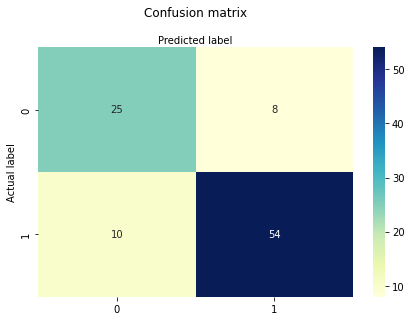

In [43]:
X1 = data[['sex', 'age', 'neck', 'waist', 'BMI', 'Detmid', 'rhtd', 'ESS', 'SB']]
y = data['result']
X_trn, X_tst, y_trn, y_tst = train_test_split(X1, y, test_size=0.2, random_state=42)
model4 = RandomForestClassifier()
model4.fit(X_trn, y_trn)
y_pred4 = model4.predict(X_tst)
matrix4 = confusion_matrix(y_tst,y_pred4)
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(matrix4), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [44]:
Mac_Feature_Selection = metrics.f1_score(y_tst, y_pred4, average ='macro')
Mic_Feature_Selection = metrics.f1_score(y_tst, y_pred4, average ='micro')
print("Macro-average: {0}".format(Mac_Feature_Selection))
print("Micro-average: {0}".format(Mic_Feature_Selection))
print(metrics.classification_report(y_tst, y_pred4))
print(metrics.confusion_matrix(y_tst, y_pred4))

Macro-average: 0.796218487394958
Micro-average: 0.8144329896907216
              precision    recall  f1-score   support

           0       0.71      0.76      0.74        33
           1       0.87      0.84      0.86        64

    accuracy                           0.81        97
   macro avg       0.79      0.80      0.80        97
weighted avg       0.82      0.81      0.82        97

[[25  8]
 [10 54]]


# Tuning

## RandomForest

Text(0.5, 257.44, 'Predicted label')

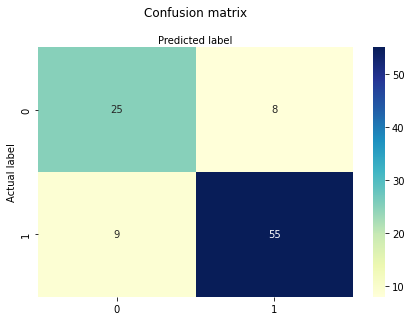

In [45]:
X = data[['sex', 'Mt', 'Detmid', 'age', 'neck', 'waist', 'BMI', 'rhtd', 'ESS', 'SB']]
y = data['result']
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, random_state=42)
model5 = RandomForestClassifier(n_estimators= 3000)
model5.fit(X_trn, y_trn)
y_pred5 = model5.predict(X_tst)
matrix5 = confusion_matrix(y_tst,y_pred5)
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(matrix5), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [46]:
Mac_Tuning = metrics.f1_score(y_tst, y_pred5, average ='macro')
Mic_Tuning = metrics.f1_score(y_tst, y_pred5, average ='micro')
print("Macro-average: {0}".format(Mac_Tuning))
print("Micro-average: {0}".format(Mic_Tuning))
print(metrics.classification_report(y_tst, y_pred5))
print(metrics.confusion_matrix(y_tst, y_pred5))

Macro-average: 0.8062051944999413
Micro-average: 0.8247422680412371
              precision    recall  f1-score   support

           0       0.74      0.76      0.75        33
           1       0.87      0.86      0.87        64

    accuracy                           0.82        97
   macro avg       0.80      0.81      0.81        97
weighted avg       0.83      0.82      0.83        97

[[25  8]
 [ 9 55]]
